In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import scipy.stats
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()


# Load in the acousticbrainz dataset into the variable 'acousticbrainz'
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV2.h5')

# Pooled variance metric
def get_variance(df):
    variances = df.groupby(level=0).var()
    samplesizes = df.groupby(level=0).size()
    
    a = variances.loc[variances.index.repeat(samplesizes)].reset_index(drop=True)
    return a

# Pooled variance metric with filtering
def get_variance_filt(df):
    filt = df.groupby(level=0).size() > 1
    filtered = df[filt[df.index.get_level_values(level=0)].values]
    return get_variance(filtered)

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Since it appeared (notebook 'Effect of audio quality on stability.ipynb') that the audio quality can have a large influence on the stability of the classifier, it is also interesting to see if the codec has an effect on the stability. First we will look at the stability accross codecs. To make sure that the codec is the only factor we are studying, we compare the codecs for the same bit rates.

These comparisons are not really fair, codecs with way more submissions have a larger probability of having more variance, thus we can take the same approach as above, but downsample so that the amount of samples per codec is the same

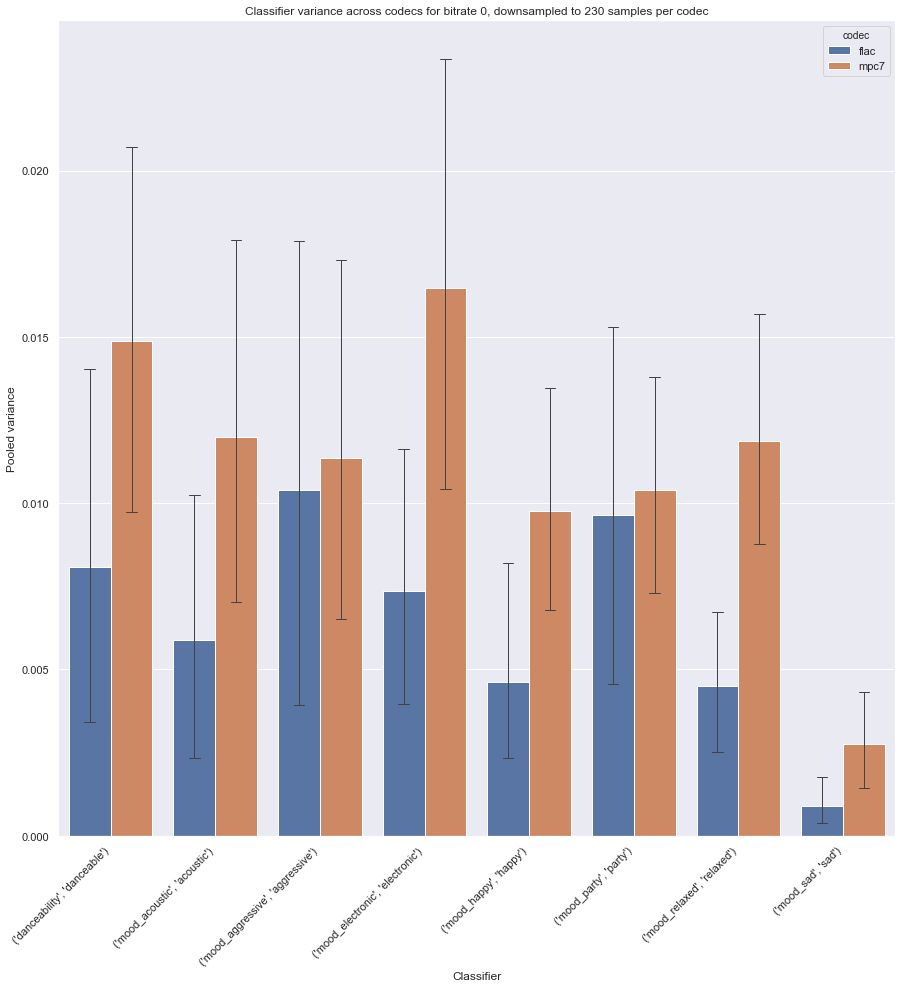

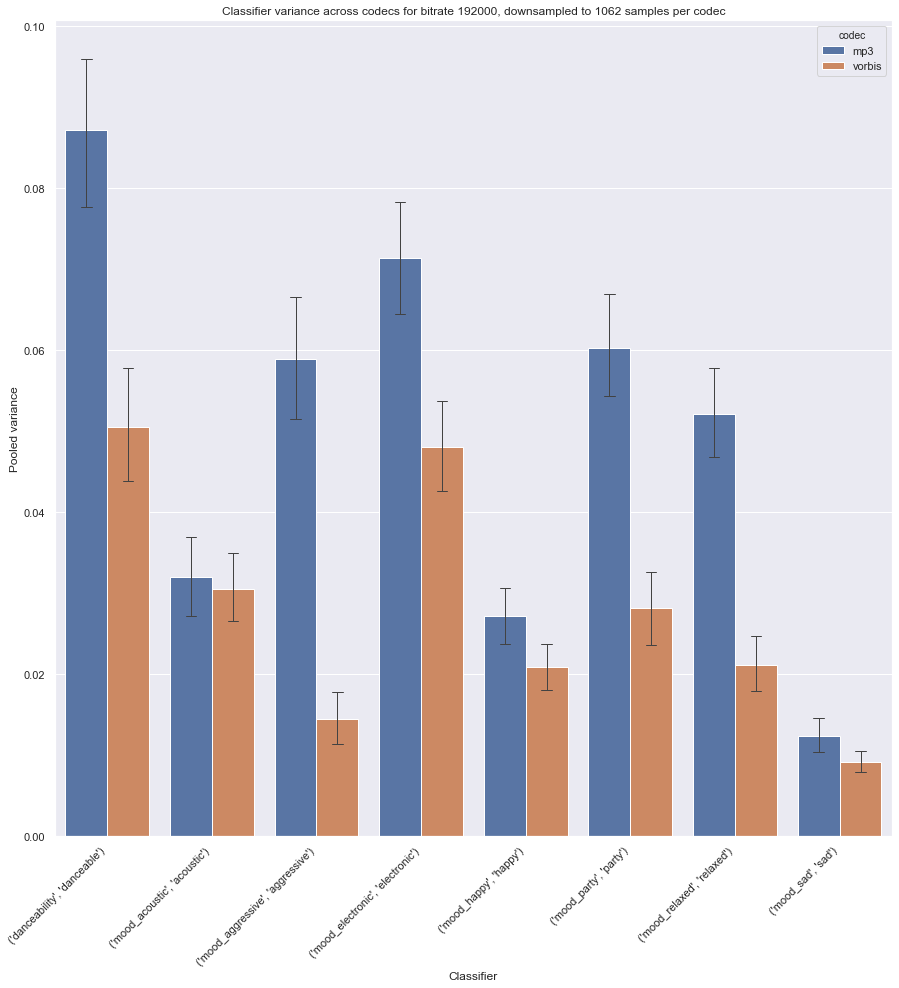

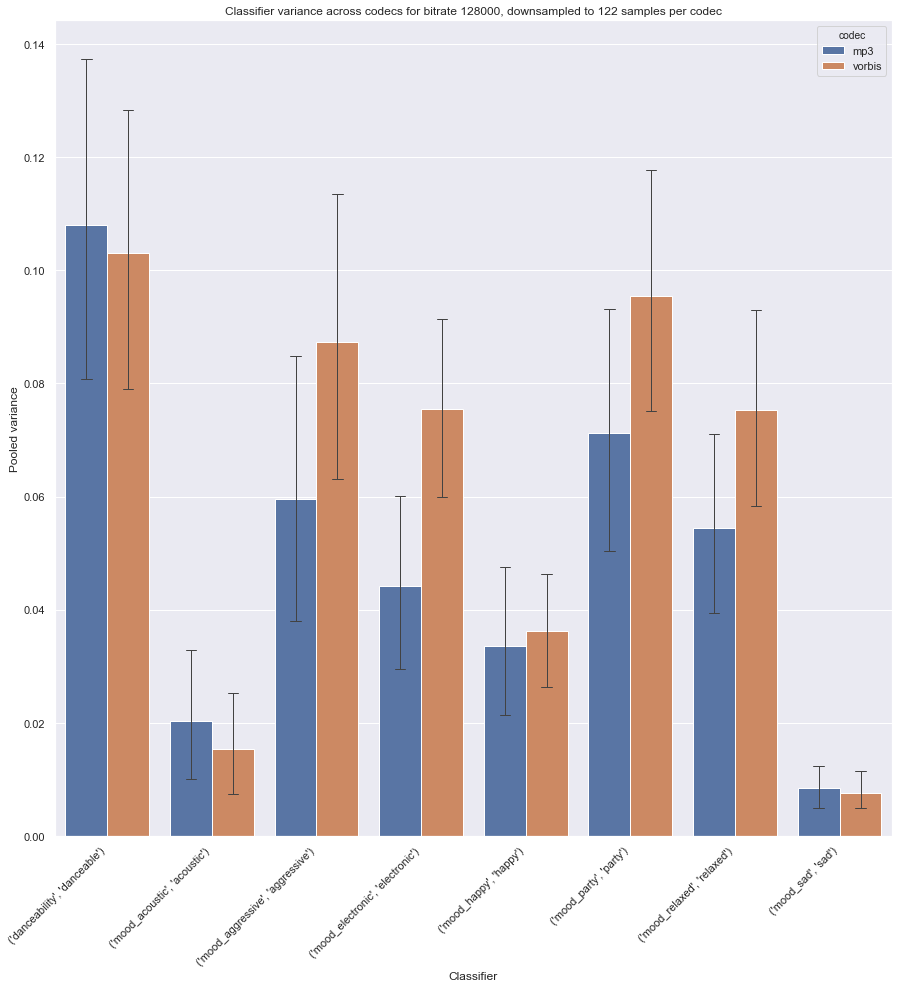

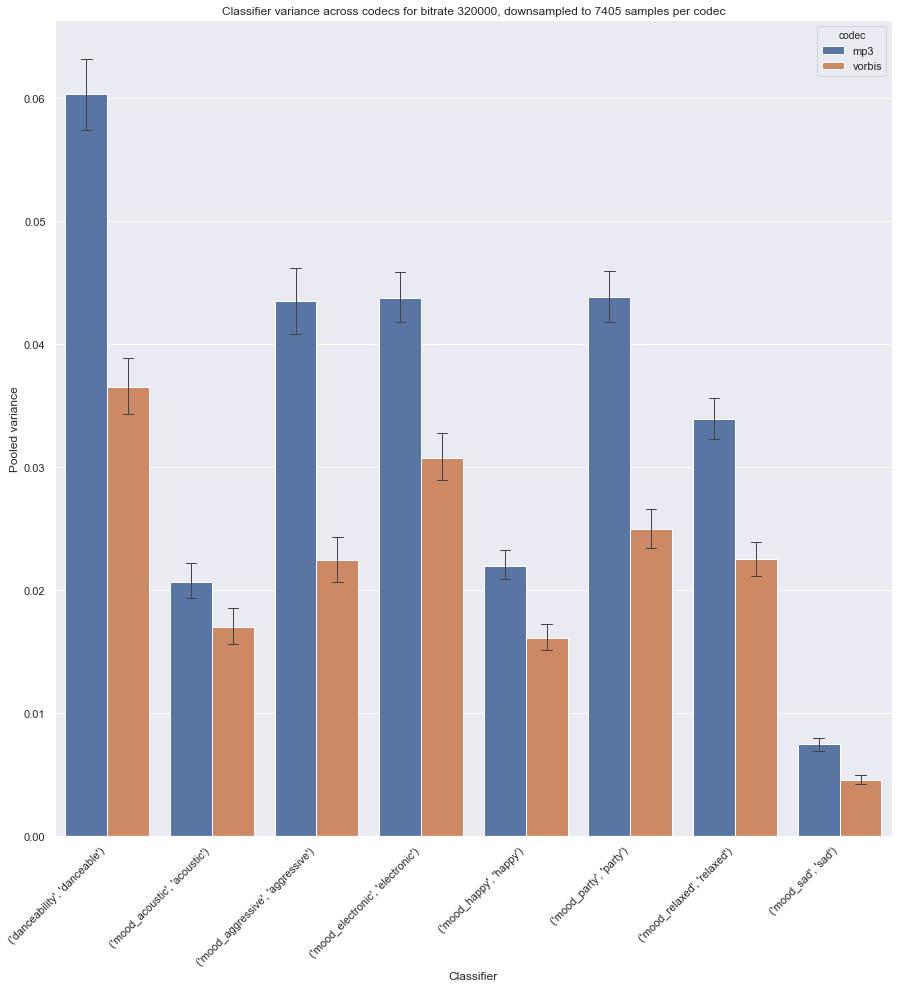

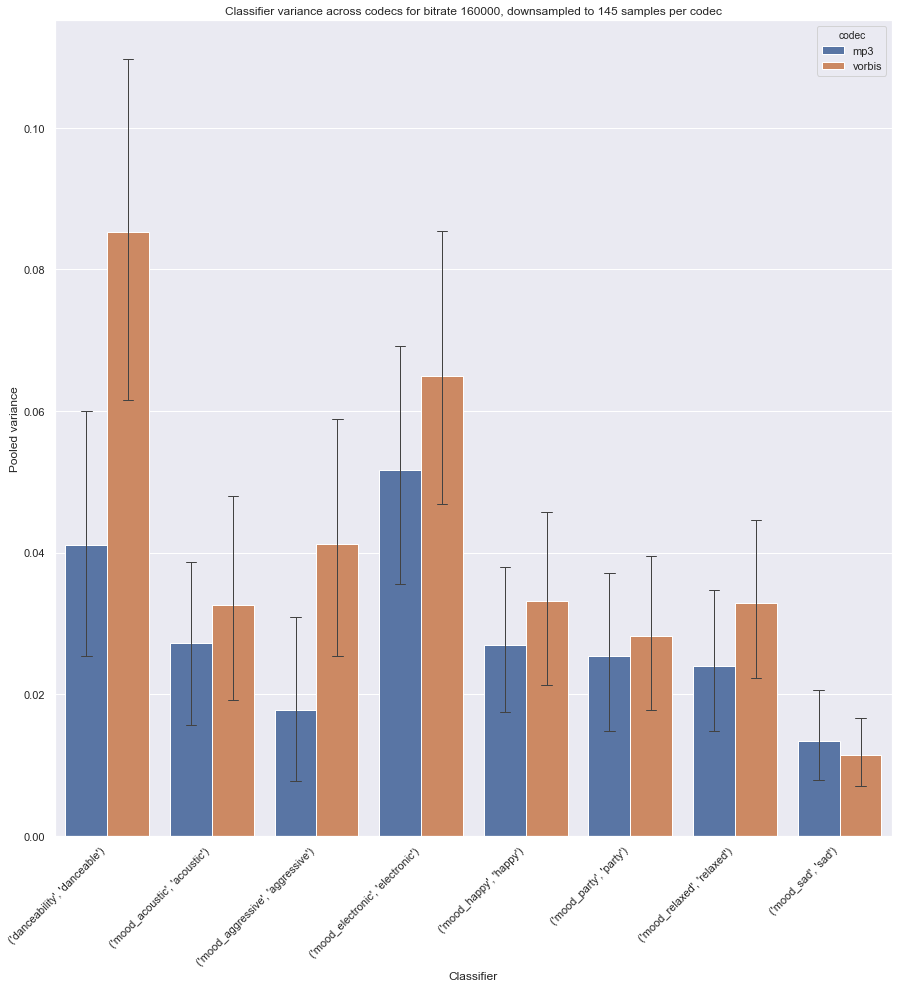

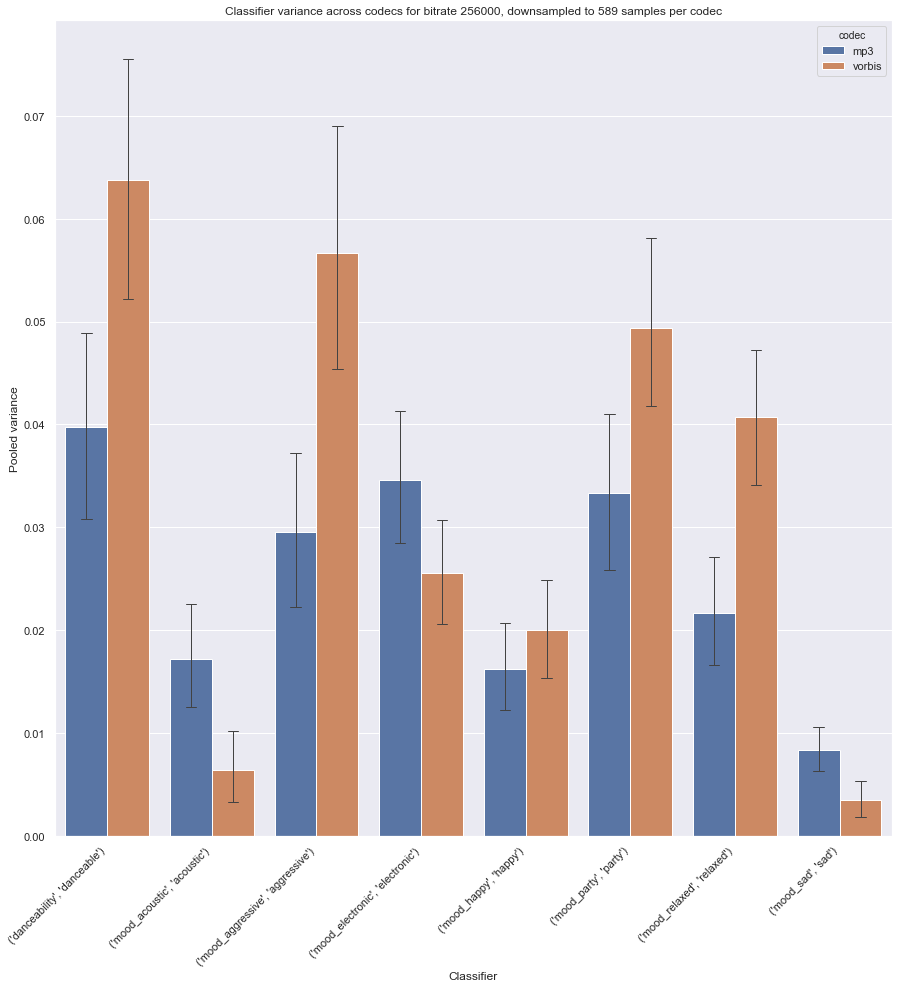

In [2]:
# Get list of common bitrates
bitrates = list(acousticbrainz['bit_rate'].value_counts()[acousticbrainz['bit_rate'].value_counts() > 10000].index)

cols = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'), ('mood_aggressive', 'aggressive'),
('mood_electronic', 'electronic'), ('mood_happy', 'happy'), ('mood_party', 'party'),
('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]



for rate in bitrates:
    # Filter by bitrate 
    filtered = acousticbrainz[acousticbrainz['bit_rate'] == rate]
    
    # Remove codecs with n < 200
    filtered = filtered.groupby('codec').filter(lambda x: len(x) >= 200)
    
    # Remove recordings with only one submission
    filt = filtered.groupby(level=0).size() > 1
    filtered = filtered[filt[filtered.index.get_level_values(level=0)].values]  
    
    # Get lowest n for codec so that we can downsample to make n equal across codecs
    n = filtered['codec'].value_counts().min()
    
    # Calculate variances
    variances = filtered[cols].apply(get_variance)
    
    # Add codec column
    variances['codec'] = filtered['codec'].values

    # Downsample
    sampled = variances.groupby('codec').apply(lambda x: x.sample(n))
    
    
    ### PLOTTING ###
    
    toplot = sampled.reset_index(drop=True)
    toplot = toplot.unstack().unstack().transpose()
    toplot = pd.melt(toplot, id_vars=['codec'])
    
    plt.figure()
    ax = sns.barplot(x='variable', y='value', hue='codec', data=toplot, ci=95, errwidth=1, capsize=.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title(f"Classifier variance across codecs for bitrate {rate}, downsampled to {n} samples per codec")
    plt.xlabel('Classifier')
    plt.ylabel('Pooled variance')
    plt.show()

And how do bitrate and codec affect the correlation with the spotify data?

In [3]:
from scipy import stats

# Load in mapping and spotify data
mapping = pd.read_hdf(Path.cwd() / 'datasets' / 'mapping.h5')
spotify = pd.read_hdf(Path.cwd() / 'datasets' / 'spotify.h5')

# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

# Define correlations to study
cols = [
    ('acousticness', ('mood_acoustic', 'acoustic')),
    ('danceability', ('danceability', 'danceable')),
    ('energy', ('mood_relaxed', 'not_relaxed')),
    ('instrumentalness', ('voice_instrumental', 'instrumental')),
    ('valence', ('mood_happy', 'happy')),
    ('valence', ('mood_sad', 'not_sad'))
]

# Get the correlations
def get_correlations(data, columns):
    corrs = {
        'classifier': [],
        'correlation': [],
        'p': [],
        'low': [],
        'high': []
    }
    for t in columns:
        corrs['classifier'].append(f"{t[0]} : {t[1]}")
        pearson_r = pearsonr_ci(data[t[0]], data[t[1]])
        corrs['correlation'].append(pearson_r[0])
        corrs['p'].append(pearson_r[1])
        corrs['low'].append(pearson_r[2])
        corrs['high'].append(pearson_r[3])
    return pd.DataFrame(corrs)

# Explicitly add mbid column to make merge possible
acousticbrainz['mbid'] = acousticbrainz.index.get_level_values(0)
merged = acousticbrainz.groupby('mbid').mean().merge(mapping, on='mbid').merge(spotify, left_on='spotify', right_on='id')



correlation  \
bitrate classifier                                                        
448000  valence : ('mood_sad', 'not_sad')                      0.283617   
        valence : ('mood_happy', 'happy')                      0.341942   
        instrumentalness : ('voice_instrumental', 'inst...     0.486600   
        energy : ('mood_relaxed', 'not_relaxed')               0.584342   
        danceability : ('danceability', 'danceable')           0.376851   
        acousticness : ('mood_acoustic', 'acoustic')           0.744341   
320000  valence : ('mood_sad', 'not_sad')                      0.016231   
        valence : ('mood_happy', 'happy')                      0.229930   
        instrumentalness : ('voice_instrumental', 'inst...     0.285627   
        energy : ('mood_relaxed', 'not_relaxed')               0.394047   
        danceability : ('danceability', 'danceable')           0.290690   
        acousticness : ('mood_acoustic', 'acoustic')           0.702885   
256000  valence : ('mood_sad', 'not_sad')                     -0.117809   
        valence : ('mood_happy', 'happy')                      0.263326   
        instrumentalness : ('voice_instrumental', 'inst...     0.059973   
        energy : ('mood_relaxed', 'not_relaxed')               0.502652   
        danceability : ('danceability', 'danceable')           0.105227   
        acousticness : ('mood_acoustic', 'acoustic')           0.667618   
192000  valence : ('mood_sad', 'not_sad')                      0.133053   
        valence : ('mood_happy', 'happy')                      0.253243   
        instrumentalness : ('voice_instrumental', 'inst...     0.308361   
        energy : ('mood_relaxed', 'not_relaxed')               0.380362   
        danceability : ('danceability', 'danceable')           0.266354   
        acousticness : ('mood_acoustic', 'acoustic')           0.587433   
160000  valence : ('mood_sad', 'not_sad')                      0.116727   
        valence : ('mood_happy', 'happy')                      0.264923   
        instrumentalness : ('voice_instrumental', 'inst...     0.318601   
        energy : ('mood_relaxed', 'not_relaxed')               0.446478   
        danceability : ('danceability', 'danceable')           0.243879   
        acousticness : ('mood_acoustic', 'acoustic')           0.607187   
128000  valence : ('mood_sad', 'not_sad')                      0.130462   
        valence : ('mood_happy', 'happy')                      0.264937   
        instrumentalness : ('voice_instrumental', 'inst...     0.289181   
        energy : ('mood_relaxed', 'not_relaxed')               0.378107   
        danceability : ('danceability', 'danceable')           0.192771   
        acousticness : ('mood_acoustic', 'acoustic')           0.577101   

                                                                        p  \
bitrate classifier                                                          
448000  valence : ('mood_sad', 'not_sad')                    0.000000e+00   
        valence : ('mood_happy', 'happy')                    0.000000e+00   
        instrumentalness : ('voice_instrumental', 'inst...   0.000000e+00   
        energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
        danceability : ('danceability', 'danceable')         0.000000e+00   
        acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
320000  valence : ('mood_sad', 'not_sad')                    1.120000e-01   
        valence : ('mood_happy', 'happy')                   2.968725e-115   
        instrumentalness : ('voice_instrumental', 'inst...  1.939101e-179   
        energy : ('mood_relaxed', 'not_relaxed')             0.000000e+00   
        danceability : ('danceability', 'danceable')        4.511521e-186   
        acousticness : ('mood_acoustic', 'acoustic')         0.000000e+00   
256000  valence : ('mood_sad', 'not_sad')                    4.486497e-10   
        valence : ('mood_happy', 'happy')             

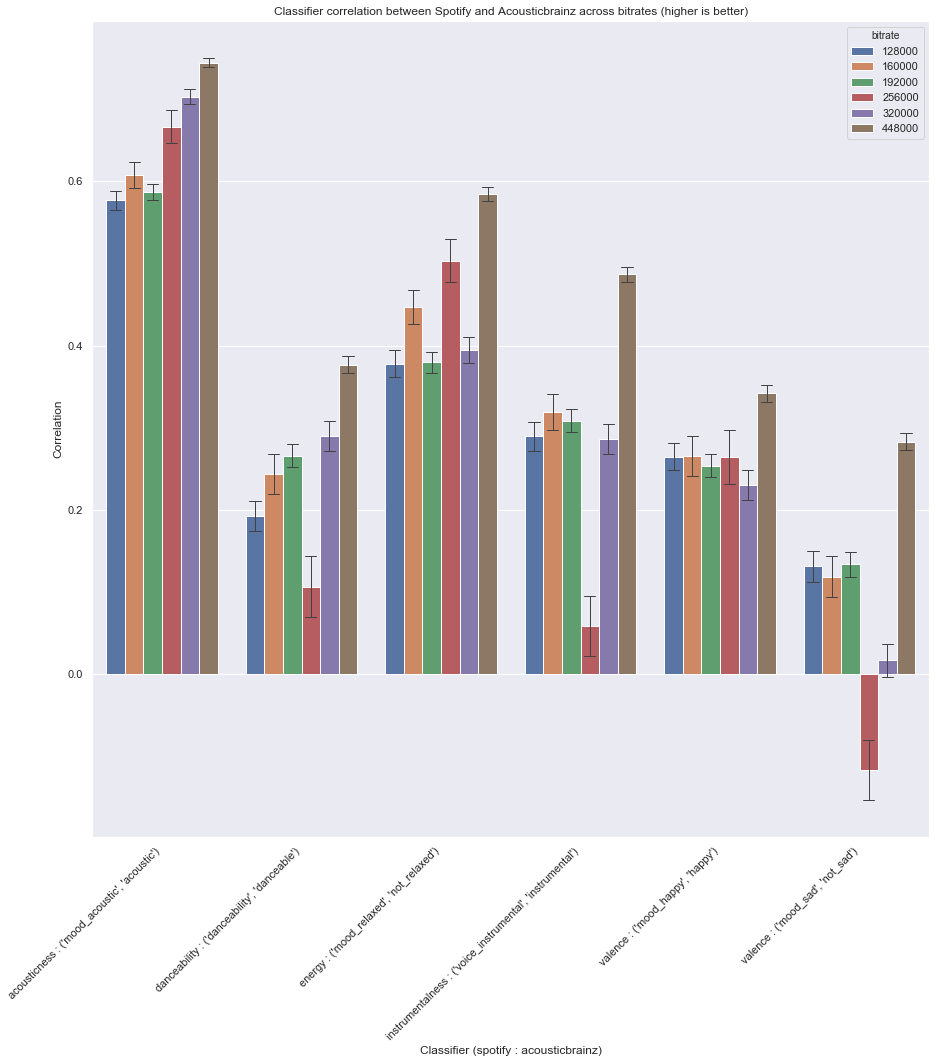

In [4]:
# Effect of bitrate
toplot = pd.DataFrame()
for rate in bitrates:
    filtered = merged[merged['bit_rate'] == rate]
    corrs = get_correlations(filtered, cols)
    
    if rate == 0:
        rate = 448000
    corrs['bitrate'] = rate
    toplot = toplot.append(corrs, ignore_index=True)
    
display(toplot.set_index(keys=['bitrate', 'classifier']).sort_index(ascending=False))

toplot['yerr'] = toplot['high'] - toplot['correlation']

#duplicate observations to get good std bars
dfCopy = toplot.copy()
duplicates = 1000 # increase this number to increase precision
for index, row in toplot.iterrows():
    for times in range(duplicates):
        new_row = row.copy()
        new_row['correlation'] = np.random.normal(row['correlation'],row['yerr']) 
        dfCopy = dfCopy.append(new_row, ignore_index=True)

# Now Seaborn does the rest
plt.figure()
ax = sns.barplot(x='classifier',
                  y='correlation',
                  hue='bitrate',
                  ci='sd',
                  data=dfCopy,
                  errwidth=1, 
                  capsize=.08)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title(f"Classifier correlation between Spotify and Acousticbrainz across bitrates (higher is better)")
plt.xlabel('Classifier (spotify : acousticbrainz)')
plt.ylabel('Correlation')
plt.show()